In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from keras.callbacks import ReduceLROnPlateau


def quantile_loss(i):
  def loss(y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(i * e, (i - 1) * e))
  return loss

X = pd.read_csv("Xtable.csv")
y= X.iloc[:,-1].values
X = X.iloc[:,1:].values

window_size = 20;
step_size = 1;

X_win_all = []
y_win_all = []

for i in range(0,len(X)-window_size,step_size):
  X_win = X[i:i+window_size]
  y_win = y[i+window_size]
  X_win_all.append(X_win)
  y_win_all.append(y_win)

X_win_all=np.array(X_win_all)
y_win_all=np.array(y_win_all)


# Although called val, all variables with val is for testing, because we train a model from scratch in every walk
X_trainval = X_win_all[:]
y_trainval = y_win_all[:]

# Walk forward Validation
shift_win = 11

# In a single walk
n_train = 10
n_valid = 1

pred_train_all = []
pred_val_all = []

true_train_all = []
true_val_all = []

rmse_train_per_walk = []
rmse_val_per_walk = []

train_idx_all = []
val_idx_all = []

hist_tr_loss = []

# Coloumns to be normalized
cols_N = np.concatenate([np.arange(8,37),np.array([38,39,41,42,44,45,47,48,50,51,53,54,56,57,58])])

for start_idx in range(0, len(X_trainval)-n_train-n_valid+1,shift_win):

  X_train = X_trainval[start_idx:start_idx+n_train]
  y_train = y_trainval[start_idx:start_idx+n_train]

  X_val = X_trainval[start_idx+n_train:start_idx+n_train+n_valid]
  y_val = y_trainval[start_idx+n_train:start_idx+n_train+n_valid]

  # Normalization

  normalizer_y = MinMaxScaler(feature_range=(-1, 1))
  normalizer_X = {}

  for k in cols_N:
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_k = X_train[:,:,k].reshape(-1,1)
    X_train_scaled = scaler_X.fit_transform(X_train_k)
    X_train[:,:,k] = X_train_scaled.reshape(X_train[:,:,k].shape)
    normalizer_X[k] = scaler_X

  for k in cols_N:
    X_val_k = X_val[:,:,k].reshape(-1,1)
    X_val_scaled = normalizer_X[k].transform(X_val_k)
    X_val[:,:,k] = X_val_scaled.reshape(X_val[:,:,k].shape)

  print("X_train shape:", X_train.shape)
  print("Feature 'open' min/max:", X_train[:, :, k].min(), X_train[:, :, k].max())

  y_train = normalizer_y.fit_transform(y_train.reshape(-1,1))
  y_val = normalizer_y.transform(y_val.reshape(-1,1))

 # fitting
  mdl = Sequential([
      Input(shape=[window_size,X_trainval.shape[2]]),
        GRU(
        units=256,
        input_shape=[window_size,X_train.shape[2]],
        activation='tanh',
      ),
      Dropout(0.2),
      Dense(1)
  ])

  mdl.compile(optimizer=Adam(learning_rate=0.001),loss=quantile_loss(0.5))

  hist = mdl.fit(X_train,
                 y_train,
                 epochs=15,
                 shuffle=False,
                 batch_size=32,
                 callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)])

  hist_tr_loss.append(hist.history['loss'])

  train_pred = mdl.predict(X_train)
  val_pred  = mdl.predict(X_val)

  train_pred = train_pred.reshape(-1,1)
  val_pred = val_pred.reshape(-1,1)

  train_pred = normalizer_y.inverse_transform(train_pred)
  val_pred = normalizer_y.inverse_transform(val_pred)

  true_train = normalizer_y.inverse_transform(y_train)
  true_val = normalizer_y.inverse_transform(y_val)

  pred_train_all.append(train_pred)
  pred_val_all.append(val_pred)

  true_train_all.append(true_train)
  true_val_all.append(true_val)

  train_idx = list(range(start_idx + window_size, start_idx + window_size + n_train))
  val_idx = list(range(start_idx + n_train + window_size, start_idx + n_train + window_size + n_valid))

  train_idx_all.append(train_idx)
  val_idx_all.append(val_idx)

  rmse_train_per_walk.append(np.sqrt(mean_squared_error(train_pred,true_train)))
  rmse_val_per_walk.append(np.sqrt(mean_squared_error(val_pred,true_val)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train shape: (10, 20, 59)
Feature 'open' min/max: -1.0 0.9999999999999982
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2201 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.3368 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.2738 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.1649 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2092 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.2057 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1586 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.1418 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1891 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1929 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1220 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4699 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2714 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3066 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2772 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2252 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1918 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1758 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1347 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1504 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1397 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1022 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4109 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2499 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2464 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1360 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1771 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1304 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1504 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1404 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0967 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0989 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1289 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2791 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4027 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2474 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2137 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2833 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1910 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1659 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1783 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2286 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2039 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1513 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2001 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2361 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1281 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1510 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1197 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1572 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1444 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1254 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1026 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1439 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1552 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3625 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2438 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1035 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1179 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1864 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1696 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1272 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0881 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0976 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0797 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1188 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2746 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.3079 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2019 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.2390 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2225 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2004 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1983 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1772 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1428 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2011 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1940 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2687 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.3906 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2155 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2124 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2491 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2019 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1318 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2167 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2096 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1815 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1213 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3888 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2419 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2324 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1794 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1970 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1531 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1140 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1286 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1323 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1437 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1237 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2994 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2567 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2070 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.1590 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1824 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1663 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1733 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1827 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1585 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1310 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1395 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3857 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2889 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1524 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1523 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2522 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1460 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1714 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1515 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1884 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1460 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0890 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3286 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.3060 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3633 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2521 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2846 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2683 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.2508 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2103 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.1858 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2489 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2397 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2861 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2829 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1383 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2031 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2001 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1424 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1983 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1699 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1542 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1125 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1431 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3007 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2184 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1291 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1158 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1357 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1074 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0975 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0976 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1151 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0715 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1012 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3822 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2173 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.1190 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - loss: 0.1975 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 0.1488 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.1738 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.1169 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0697 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0765 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1116 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0922 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2327 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1564 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2309 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1010 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2679 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2544 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1633 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1017 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0964 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1345 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1130 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4364 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.2417 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2918 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2498 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1481 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1857 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1546 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1309 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1355 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1209 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1554 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2384 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1867 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1862 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2148 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1378 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1495 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1648 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1298 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1604 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1131 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1211 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2147 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.3648 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.2021 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2170 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2054 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1612 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2014 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1443 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1463 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1833 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1673 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3295 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.3292 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2519 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2627 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2545 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2041 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1901 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2217 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1920 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2047 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2029 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4349 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3270 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2981 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.2944 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.3136 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1996 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2043 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2155 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2367 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2560 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.2783 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3734 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2585 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3451 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2743 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1738 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1686 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1862 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1694 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1519 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1702 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1670 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3254 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1238 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1196 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2144 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2472 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1907 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0744 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1430 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1227 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0651 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0724 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2547 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2517 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1137 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1832 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0928 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1275 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1393 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0985 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0873 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1658 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1980 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3263 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3167 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2082 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1139 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1550 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0880 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1163 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1177 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0981 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0910 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0901 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2534 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3145 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2219 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2983 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2396 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2471 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2262 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.2065 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.1785 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1529 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1854 - learning_rate: 5.0000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2809 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.4619 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2729 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2884 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3401 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2771 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1622 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1762 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2214 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2187 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3015 - learning_rate: 2.5000e-04
Epoch 12/15
1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2117 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2281 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1925 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2417 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2301 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2178 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1340 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1618 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1711 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1528 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1762 - learning_rate: 2.5000e-04
Epoch 12/15
1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2382 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.3295 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2414 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2270 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2392 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2344 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1981 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2290 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1990 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1825 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1919 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2705 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2846 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2494 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2286 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2727 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1851 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2188 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2403 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2434 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1800 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1859 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3180 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.3153 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.2490 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1390 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2160 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1848 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1448 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0873 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1197 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1213 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1146 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3340 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1898 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1520 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0751 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2195 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2472 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1396 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0947 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0878 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1656 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1362 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3948 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2743 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1579 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1829 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1091 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1141 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1246 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1519 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0921 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0848 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1380 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2710 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2369 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2549 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1608 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1701 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1568 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1560 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1623 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1684 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0858 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1418 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2681 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3363 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3003 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2394 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2364 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2478 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1970 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1635 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1451 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1159 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1348 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3838 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.2659 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2213 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1654 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1936 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1969 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1806 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.1422 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1544 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1874 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1289 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2851 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.3119 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1295 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1168 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2316 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1689 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1247 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2624 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2351 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2177 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2067 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3567 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2412 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1842 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1481 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2257 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1672 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1425 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1303 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1021 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1236 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1748 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1955 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2318 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1817 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2620 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2052 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1391 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1684 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1159 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1374 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1232 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1495 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2708 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2500 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1692 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2255 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1237 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1268 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1908 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0854 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1190 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1476 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1272 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3077 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2735 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1829 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1291 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1743 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1274 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1595 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2140 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1976 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1341 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1304 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2407 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2727 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2139 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1461 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1801 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1390 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1398 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0889 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0716 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0856 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1000 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2407 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2559 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1743 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2246 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1148 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2358 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1877 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1531 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1405 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2050 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1946 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4178 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2261 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2470 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1399 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1913 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2212 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1989 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2197 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2061 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1866 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1691 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4389 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2730 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3094 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2486 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2437 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2032 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1565 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1852 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2013 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1408 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0955 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3567 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.3072 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.3059 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1844 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1893 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2395 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2087 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2010 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1748 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1801 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1266 - learning_rate: 5.0000e-04
Epoch 12/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3407 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2928 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2990 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1690 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1892 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2366 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2005 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1326 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1904 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1044 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0881 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5873 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2858 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.3077 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.2086 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.1070 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0890 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0908 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1228 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0770 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0858 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1046 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3673 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2714 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1882 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2229 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2255 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2536 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2127 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1621 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1654 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1782 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1674 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3186 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2450 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1458 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1951 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1197 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1185 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1414 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0870 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.1006 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1423 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.1247 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2858 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2327 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2097 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2414 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2384 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2026 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1851 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1882 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1735 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1464 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1294 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3586 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1751 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1534 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1285 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1315 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1019 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1141 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1045 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.1033 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0683 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0894 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3931 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.3112 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2156 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1927 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1897 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1695 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2006 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1486 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2269 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0882 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1138 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2125 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1300 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2096 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2292 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2020 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1404 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1129 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0832 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0702 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1125 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1075 - learning_rate: 5.0000e-04
Epoch 12/15
1/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3845 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3460 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.2841 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.2435 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2288 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2595 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2464 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2156 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2153 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1984 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1933 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2953 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1843 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1113 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0794 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1422 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0999 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1075 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0841 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0794 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0900 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0956 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2971 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.3960 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2059 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2125 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2613 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2072 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1935 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2344 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1396 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1428 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1639 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3498 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.3430 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.2613 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3143 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2572 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2377 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2328 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2352 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2255 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1853 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2268 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2419 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2381 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1514 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2277 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2034 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2206 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1974 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1666 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1721 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1547 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1617 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2367 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2092 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1300 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2115 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1891 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1294 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1355 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0704 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.0914 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1337 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1741 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3505 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.3448 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1790 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1522 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1086 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0839 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1284 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1447 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1430 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0877 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0903 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2334 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3274 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2243 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1953 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2899 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2455 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1400 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1723 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2654 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2512 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1534 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3124 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.2975 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1685 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1818 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2467 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1248 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1503 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.1491 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1396 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1066 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1139 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3500 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2257 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1145 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1769 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2127 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1654 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1088 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1458 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1276 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1443 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1639 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3329 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2933 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1520 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1488 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2038 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1777 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1240 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1140 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1683 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1502 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1183 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2649 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2125 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1038 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1222 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1133 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1781 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0435 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1018 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0879 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1342 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1184 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3483 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2879 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2424 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1536 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1803 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1997 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1821 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1976 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1844 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1272 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1645 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2881 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.3435 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2639 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.2633 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.2212 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2424 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.2168 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.1675 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1553 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1538 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1674 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4279 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2971 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3670 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3635 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2527 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2447 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2034 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2456 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1923 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1790 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1432 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3641 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1893 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1643 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1884 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1496 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1378 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1376 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1033 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1171 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.1740 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1448 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3302 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2166 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1450 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1172 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1362 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1255 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1148 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1478 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0764 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1585 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1074 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3238 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2959 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1453 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1656 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1546 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0967 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1826 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1475 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1200 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1350 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0999 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3025 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2136 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1995 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1480 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1189 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.1471 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1528 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1552 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1232 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1411 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1163 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4200 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3396 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1810 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1380 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1556 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1425 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1409 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1805 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1663 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1636 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1366 - learning_rate: 2.5000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4991 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2415 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3477 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3451 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3020 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1643 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2069 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1976 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2242 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1716 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1817 - learning_rate: 2.5000e-04
Epoch 12/15
1/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3998 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1953 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2927 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2049 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1973 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2910 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2679 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2173 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1304 - learning_rate: 2.5000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1503 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1598 - learning_rate: 2.5000e-04
Epoch 12/15
1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4451 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2358 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2033 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2816 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2137 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1427 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1414 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1304 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1119 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1223 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0914 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.3108 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3073 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2992 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1937 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2382 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2593 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2299 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2060 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1885 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1752 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1895 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2747 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1994 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1040 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2424 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1151 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1114 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0833 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0653 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1002 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1118 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1439 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2443 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3271 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2102 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2128 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2935 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2727 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2480 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1530 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1237 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0943 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1111 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2597 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2807 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1623 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1670 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1361 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1379 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1206 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1556 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1235 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1098 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0639 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2281 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3626 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2937 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3136 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2539 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1927 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.2489 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2382 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2395 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.2268 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2117 - learning_rate: 2.5000e-04
Epoch 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3265 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2739 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2456 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1303 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1823 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2267 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1993 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0634 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1081 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0900 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1447 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3236 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2756 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2094 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1918 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2188 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1918 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1452 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1833 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1673 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1615 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1299 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2430 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1385 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2754 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1695 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1531 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1628 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1960 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1444 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1462 - learning_rate: 2.5000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1338 - learning_rate: 2.5000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1360 - learning_rate: 2.5000e-04
Epoch 12/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2930 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2861 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2689 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2345 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.3016 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2650 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1704 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1503 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1693 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1610 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1658 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.3268 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.3126 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.1708 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1401 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2456 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1587 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1497 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2292 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1864 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1339 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1023 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3666 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3801 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3772 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3432 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.3293 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3598 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2265 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2671 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.2623 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2417 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.1932 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3158 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.2897 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2750 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.2040 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.1915 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.1950 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1983 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2205 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.1924 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1756 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2082 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2333 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.3266 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.3800 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3213 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2032 - learning_rate: 5.0000e-04
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2252 - learning_rate: 5.0000e-04
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1926 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1865 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1919 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1964 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1515 - learning_rate: 5.0000e-04
Epoch 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2465 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2590 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2025 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3930 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.3992 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2588 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1872 - learning_rate: 5.0000e-04
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2128 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1750 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2461 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2119 - learning_rate: 5.0000e-04
Epoch 12/15
1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4336 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2498 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.4495 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.3382 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2349 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1897 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2120 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2643 - learning_rate: 0.0010
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1866 - learning_rate: 0.0010
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1718 - learning_rate: 0.0010
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1453 - learning_rate: 0.0010
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3116 - learning_rate: 0.0010
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3515 - learning_rate: 0.0010
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4175 - learning_rate: 0.0010
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2225 - learning_rate: 0.0010
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2812 - learning_rate: 0.0010
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3065 - learning_rate: 0.0010
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2630 - learning_rate: 0.0010
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2461 - learning_rate: 5.0000e-04
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2171 - learning_rate: 5.0000e-04
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1940 - learning_rate: 5.0000e-04
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2166 - learning_rate: 5.0000e-04
Epoch 12/15
1/1 ━━━━

In [ ]:
pred_err_val = []
true_err_val = []

for i in range(len(pred_val_all)):
  idx = [idx for idx in val_idx_all[i] if idx < len(y)]
  pred_err_val.extend(pred_val_all[i].flatten()[:len(idx)])
  true_err_val.extend(y[idx])

rmse_val_err = np.sqrt(mean_squared_error(pred_err_val,true_err_val))
r2_val_err = r2_score(pred_err_val,true_err_val)
mae_val_err = mean_absolute_error(pred_err_val,true_err_val)
mape_val_err = mean_absolute_percentage_error(pred_err_val,true_err_val)
acc_val_err = (1-mae_val_err/np.mean(true_err_val))*100

pred_err_train = []
true_err_train = []

for i in range(len(pred_train_all)):
  idx = [idx for idx in train_idx_all[i] if idx < len(y)]
  pred_err_train.extend(pred_train_all[i].flatten()[:len(idx)])
  true_err_train.extend(y[idx])

rmse_train_err = np.sqrt(mean_squared_error(pred_err_train,true_err_train))
r2_train_err = r2_score(pred_err_train,true_err_train)
mae_train_err = mean_absolute_error(pred_err_train,true_err_train)
mape_train_err = mean_absolute_percentage_error(pred_err_train,true_err_train)
acc_train_err = (1-mae_train_err/np.mean(true_err_train))*100

print(f"TRAIN RMSE: {rmse_train_err}")
print(f"TRAIN R2: {r2_train_err}")
print(f"TRAIN MAE: {mae_train_err}")
print(f"TRAIN MAPE: {mape_train_err}")
print(f"TRAIN ACC: {acc_train_err}")

print(f"TEST RMSE: {rmse_val_err}")
print(f"TEST R2: {r2_val_err}")
print(f"TEST MAE: {mae_val_err}")
print(f"TEST MAPE: {mape_val_err}")
print(f"TEST ACC: {acc_val_err}")

TRAIN RMSE: 63.56609435698632
TRAIN R2: 0.999636779475637
TRAIN MAE: 40.16513318002354
TRAIN MAPE: 0.0070451942409244794
TRAIN ACC: 99.29174427259768
TEST RMSE: 131.39237524840178
TEST R2: 0.9984478472397017
TEST MAE: 93.40873645413303
TEST MAPE: 0.017172593941735946
TEST ACC: 98.36360256282143


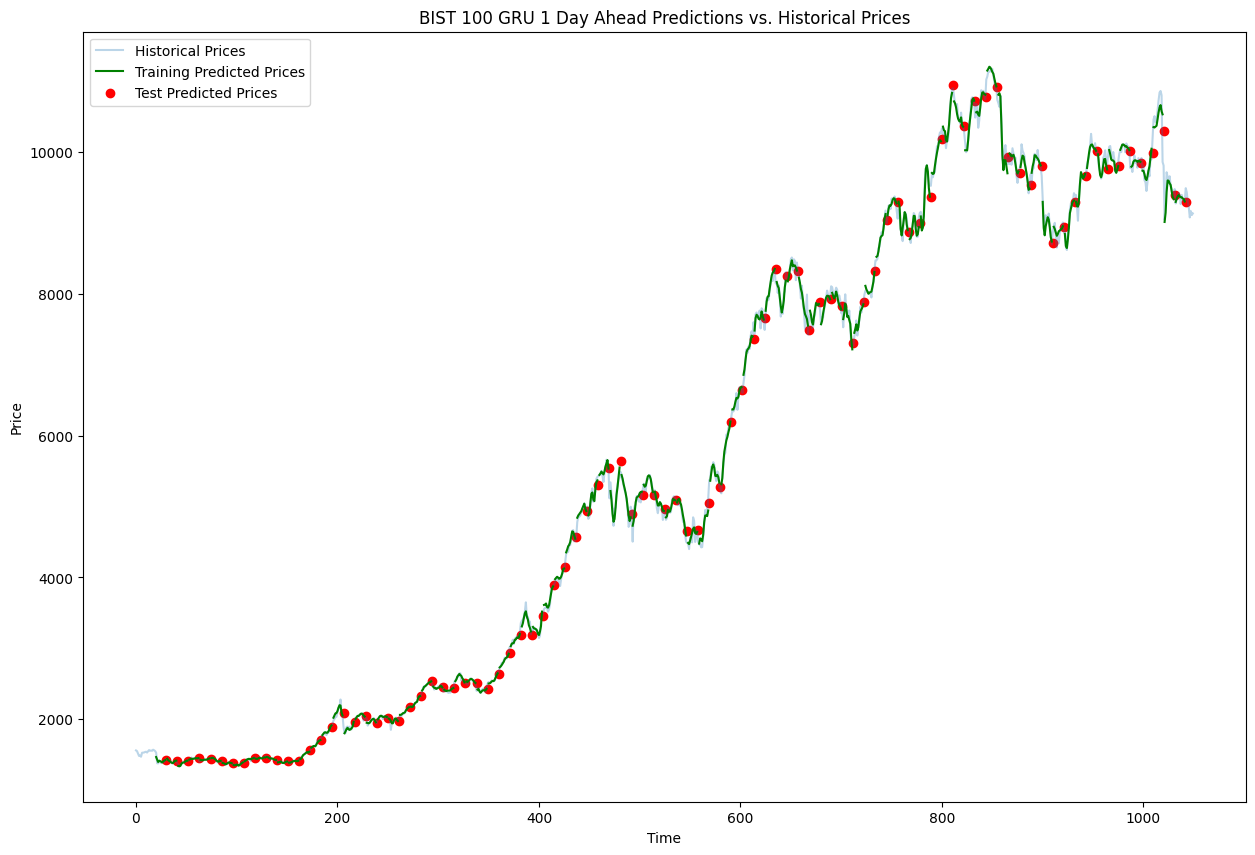

In [ ]:
train_idx = list(range(window_size, window_size + len(train_pred)+1))
val_idx = list(range(window_size + len(train_pred),+ window_size + len(train_pred) + len(val_pred)+1))

plt.figure(figsize=(15,10))

plt.plot(range(len(y)),y, label='Historical Prices', alpha=0.3)

for i in range(len(pred_train_all)):
  if i >= 1:
    plt.plot(train_idx_all[i],pred_train_all[i], color="green")
  else:
    plt.plot(train_idx_all[i],pred_train_all[i], label='Training Predicted Prices', color="green")

for i in range(len(pred_val_all)):
  if i >= 1:
    plt.scatter(val_idx_all[i],pred_val_all[i], color="red")
  else:
    plt.scatter(val_idx_all[i],pred_val_all[i], label='Test Predicted Prices', color="red")


plt.title('BIST 100 GRU 1 Day Ahead Predictions vs. Historical Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
pred_val_all_flat = np.concatenate([p.flatten() for p in pred_val_all])
true_val_all_flat = np.concatenate([p.flatten() for p in true_val_all])
res = true_val_all_flat - pred_val_all_flat

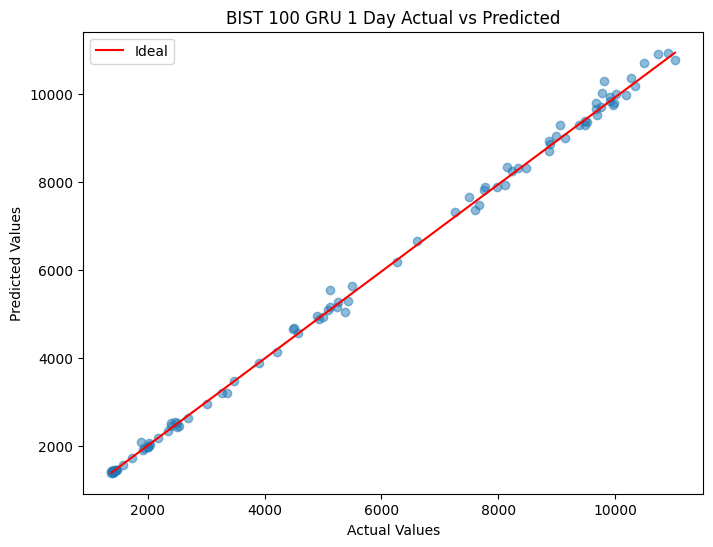

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(true_val_all_flat, pred_val_all_flat, alpha=0.5)
plt.plot([min(true_val_all_flat),max(true_val_all_flat)],[min(pred_val_all_flat),max(pred_val_all_flat)],"r", label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("BIST 100 GRU 1 Day Actual vs Predicted")
plt.legend()
plt.show()

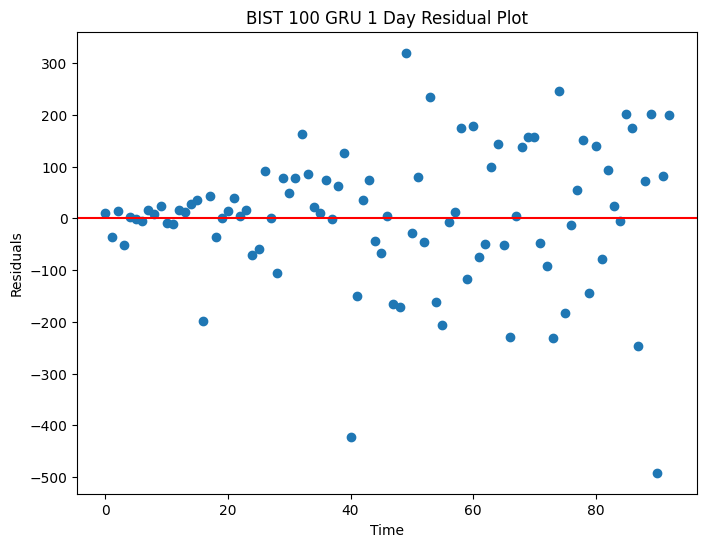

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(range(len(res)),res)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("BIST 100 GRU 1 Day Residual Plot")
plt.show()


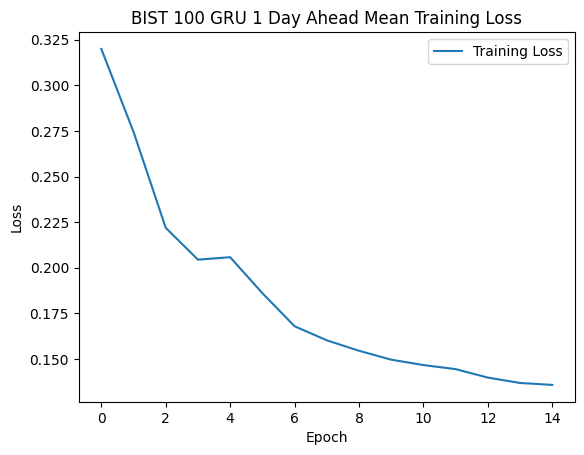

In [ ]:
hist_tr_loss = np.array(hist_tr_loss)

hist_tr_loss_mean = np.mean(hist_tr_loss, axis=0)

plt.plot(hist_tr_loss_mean, label='Training Loss')
plt.title('BIST 100 GRU 1 Day Ahead Mean Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()